# StarGANv2-VC Demo (VCTK 20 Speakers)

### Utils

In [3]:
%cd ..


/root/timbre/timbre_transfer/new/StarGANv2-VC


In [4]:
# load packages
import random
import yaml
from munch import Munch
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import librosa
import os
import librosa.display

# from Utils.ASR.models import ASRCNN
# from Utils.JDC.model import JDCNet
from models import Generator, MappingNetwork, StyleEncoder

%matplotlib inline

In [112]:
# Source: http://speech.ee.ntu.edu.tw/~jjery2243542/resource/model/is18/en_speaker_used.txt
# Source: https://github.com/jjery2243542/voice_conversion

speakers = [225,228,229,230,231,233,236,239,240,244,226,227,232,243,254,256,258,259,270,273]

to_mel = torchaudio.transforms.MelSpectrogram(
    n_mels=80, n_fft=1024, win_length=1024, hop_length=256)
mean, std = -4, 4

def preprocess(input):
    # wave_tensor = torch.from_numpy(wave).float()
    # mel_tensor = to_mel(wave_tensor)
    mel_tensor = torch.from_numpy(input)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor

def inverse_preprocess(output):
    mel = np.exp(output * std + mean) - 1e-5

    return mel

def build_model(model_params={}):
    args = Munch(model_params)
    generator = Generator(args.dim_in, args.style_dim, args.max_conv_dim, w_hpf=args.w_hpf, F0_channel=args.F0_channel)
    mapping_network = MappingNetwork(args.latent_dim, args.style_dim, args.num_domains, hidden_dim=args.max_conv_dim)
    style_encoder = StyleEncoder(args.dim_in, args.style_dim, args.num_domains, args.max_conv_dim)
    
    nets_ema = Munch(generator=generator,
                     mapping_network=mapping_network,
                     style_encoder=style_encoder)

    return nets_ema

def compute_style(speaker_dicts):
    reference_embeddings = {}
    for key, (path, speaker) in speaker_dicts.items():
        if path == "":
            label = torch.LongTensor([speaker]).to('cuda')
            latent_dim = starganv2.mapping_network.shared[0].in_features
            ref = starganv2.mapping_network(torch.randn(1, latent_dim).to('cuda'), label)
        else:
            wave, sr = librosa.load(path, sr=16000)
            audio, index = librosa.effects.trim(wave, top_db=30)
            if sr != 16000:
                wave = librosa.resample(wave, sr, 16000)
            mel_tensor = preprocess(wave).to('cuda')

            with torch.no_grad():
                label = torch.LongTensor([speaker])
                ref = starganv2.style_encoder(mel_tensor.unsqueeze(1), label)
        reference_embeddings[key] = (ref, label)
    
    return reference_embeddings

### Load models

In [123]:
# load F0 model

F0_model = JDCNet(num_class=1, seq_len=192)
params = torch.load("Utils/JDC/bst.t7")['net']
F0_model.load_state_dict(params)
_ = F0_model.eval()
F0_model = F0_model.to('cuda')

NameError: name 'JDCNet' is not defined

In [122]:
# load vocoder
from parallel_wavegan.utils import load_model
vocoder = load_model("Vocoder/checkpoint-400000steps.pkl").to('cuda').eval()
vocoder.remove_weight_norm()
_ = vocoder.eval()

ModuleNotFoundError: No module named 'parallel_wavegan'

In [124]:
# load starganv2

model_path = '/root/timbre/timbre_transfer/new/StarGANv2-VC/Models/VCTK20/checkpoint.pth'

with open('Models/VCTK20/config.yml') as f:
    starganv2_config = yaml.safe_load(f)
starganv2 = build_model(model_params=starganv2_config["model_params"])
params = torch.load(model_path, map_location='cpu')
params = params['model_ema']
_ = [starganv2[key].load_state_dict(params[key]) for key in starganv2]
_ = [starganv2[key].eval() for key in starganv2]
starganv2.style_encoder = starganv2.style_encoder.to('cuda')
starganv2.mapping_network = starganv2.mapping_network.to('cuda')
starganv2.generator = starganv2.generator.to('cuda')

### Conversion

[[0.25267288 0.3168483  0.3495854  ... 0.31423363 0.32262984 0.33576486]
 [0.39563736 0.46135926 0.5139702  ... 0.41193673 0.3967898  0.41265675]
 [0.398144   0.4893191  0.55287737 ... 0.4686471  0.46560016 0.42075145]
 ...
 [0.04044144 0.07324836 0.08692306 ... 0.0264032  0.02250511 0.04434845]
 [0.         0.0335405  0.06455429 ... 0.03383453 0.03024681 0.02563255]
 [0.         0.02907722 0.03968948 ... 0.0346698  0.02780563 0.01750587]]
[[[ 0.31220937  0.42535883  0.47451675 ...  0.42121607  0.4343992
    0.45435005]
  [ 0.5363873   0.6132226   0.6672145  ...  0.55657196  0.53784156
    0.5574451 ]
  [ 0.53954506  0.64264023  0.70369864 ...  0.6210587   0.6177975
    0.5671576 ]
  ...
  [-0.6024263  -0.3064841  -0.22103524 ... -0.81357443 -0.89211845
   -0.5565709 ]
  [-1.8782313  -0.6952884  -0.3695252  ... -0.6909623  -0.7464645
   -0.8281697 ]
  [-1.8782313  -0.76596045 -0.6117525  ... -0.67887187 -0.7880455
   -1.0145819 ]]]


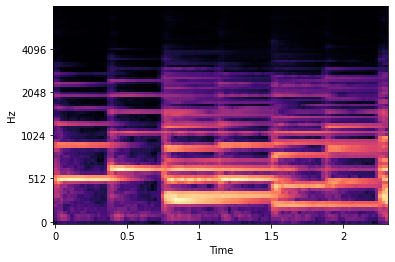

In [119]:
# load input wave
# selected_speakers = [273, 259, 258, 243, 254, 244, 236, 233, 230, 228]
# k = random.choice(selected_speakers)
wav_path = '/root/timbre/data_syn/cropped/' + "piano_all_00.wav"
audio, source_sr = librosa.load(wav_path, sr=16000)
audio = audio / np.max(np.abs(audio))
audio.dtype = np.float32

a = np.load("/root/timbre/data_syn/cropped/piano_all_00.wav.spec.npy")
a = a[:, :128]


print(a)
# print(b)

a = a ** 2

librosa.display.specshow(a[:, :100],
                         y_axis='mel', fmax=8000, x_axis='time')
a = preprocess(a).numpy()

print(a)

# preprocessed = preprocess(audio).numpy()
# print(preprocessed.shape)

# inverse_preprocess(preprocessed).shape

# librosa.display.specshow(preprocessed[0, :, :100],
#                          y_axis='mel', fmax=8000, x_axis='time')



#### Convert by style encoder

In [116]:
# with reference, using style encoder
instrument_list = ['piano', 'epiano', 'viola', 'guitar', 'flute', 'trumpet', 'harp', 'organ']
speaker_dicts = {}
for ins in instrument_list:
    speaker_dicts[ins] = ('/root/timbre/data_syn/cropped/' + ins + '_all' + '_00.wav', instrument_list.index(ins))

reference_embeddings = compute_style(speaker_dicts)

RuntimeError: Given input size: (128x1x3200000). Calculated output size: (128x0x1600000). Output size is too small

torch.Size([1, 80, 128])
[[ 1.2317834e-04  5.1471045e-05  7.8623809e-05 ...  2.1581832e-02
   2.2552628e-02  8.2730362e-03]
 [ 2.2865166e-05  2.1816853e-05  1.8335113e-05 ...  3.1004811e-02
   2.5341110e-02  4.5430292e-03]
 [ 4.3737027e-06  2.0722391e-06 -4.8899165e-07 ...  3.2458980e-02
   2.3328712e-02  3.8163438e-03]
 ...
 [-3.5897906e-06 -5.0031513e-06 -3.1245413e-06 ...  2.5798711e-01
   2.5147617e-01  1.7072605e-02]
 [ 1.8038614e-05  1.3732875e-05  1.9375757e-05 ...  1.8521225e-01
   2.4543148e-01  2.4384413e-02]
 [ 2.6312092e-04  3.4941456e-04  4.1494222e-04 ...  1.4840594e-01
   2.0504534e-01  6.4064436e-02]]


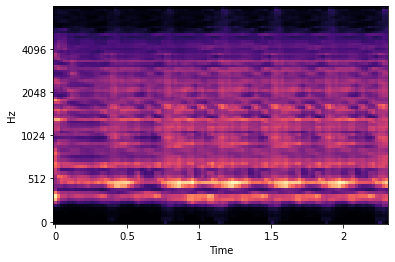

In [125]:
# conversion 
import time
start = time.time()
    
source = torch.from_numpy(a).to('cuda:0')
print(source.shape)
keys = []
converted_samples = {}
reconstructed_samples = {}
converted_mels = {}

for key, (ref, _) in reference_embeddings.items():
    with torch.no_grad():
        # f0_feat = F0_model.get_feature_GAN(source.unsqueeze(1))
        out = starganv2.generator(source.unsqueeze(1), ref)
        
        c = out.transpose(-1, -2).squeeze().cpu()

        c = c.numpy()

        c = inverse_preprocess(c)
        print(c)

        c = c.T

        # c = c ** 0.5

        np.save("result" + key + ".npy", c)

        librosa.display.specshow(c[:, :100],
                         y_axis='mel', fmax=8000, x_axis='time')

        break


#### Convert by mapping network

In [ ]:
# no reference, using mapping network
speaker_dicts = {}
selected_speakers = [273, 259, 258, 243, 254, 244, 236, 233, 230, 228]
for s in selected_speakers:
    k = s
    speaker_dicts['p' + str(s)] = ('', speakers.index(s))

reference_embeddings = compute_style(speaker_dicts)

In [ ]:
# conversion 
import time
start = time.time()
    
source = preprocess(audio).to('cuda:0')
keys = []
converted_samples = {}
reconstructed_samples = {}
converted_mels = {}

for key, (ref, _) in reference_embeddings.items():
    with torch.no_grad():
        f0_feat = F0_model.get_feature_GAN(source.unsqueeze(1))
        out = starganv2.generator(source.unsqueeze(1), ref, F0=f0_feat)
        
        c = out.transpose(-1, -2).squeeze().to('cuda')
        y_out = vocoder.inference(c)
        y_out = y_out.view(-1).cpu()

        if key not in speaker_dicts or speaker_dicts[key][0] == "":
            recon = None
        else:
            wave, sr = librosa.load(speaker_dicts[key][0], sr=16000)
            mel = preprocess(wave)
            c = mel.transpose(-1, -2).squeeze().to('cuda')
            recon = vocoder.inference(c)
            recon = recon.view(-1).cpu().numpy()

    converted_samples[key] = y_out.numpy()
    reconstructed_samples[key] = recon

    converted_mels[key] = out
    
    keys.append(key)
end = time.time()
print('total processing time: %.3f sec' % (end - start) )

import IPython.display as ipd
for key, wave in converted_samples.items():
    print('Converted: %s' % key)
    display(ipd.Audio(wave, rate=16000))
    print('Reference (vocoder): %s' % key)
    if reconstructed_samples[key] is not None:
        display(ipd.Audio(reconstructed_samples[key], rate=16000))

print('Original (vocoder):')
wave, sr = librosa.load(wav_path, sr=16000)
mel = preprocess(wave)
c = mel.transpose(-1, -2).squeeze().to('cuda')
with torch.no_grad():
    recon = vocoder.inference(c)
    recon = recon.view(-1).cpu().numpy()
display(ipd.Audio(recon, rate=16000))
print('Original:')
display(ipd.Audio(wav_path, rate=16000))